In [1]:
'''
train_path = '/kaggle/input/tempdata1'

# save all files to kaggle/files/images
path = '/kaggle/working/images'

from zipfile import ZipFile as zipper
with zipper(train_path, 'r') as zipp:
    zipp.extractall(destination)
    
with zipper(test_path, 'r') as zipp:
    zipp.extractall(destination)import os
'''

import torch
import torchvision.models
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt 

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

transform = transforms.Compose([
    transforms.Resize([64, 60]),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()    
])

def f(t):
    return torch.tensor([t]).float()

Using cuda device


In [2]:
path = '/kaggle/input/chinafutureohlc/train/20'
ds = datasets.ImageFolder(path, transform = transform, target_transform= f)

print(ds.class_to_idx)

from torch.utils.data import random_split

ds_train, ds_valid = random_split(
    dataset=ds,
    lengths=[.7, .3],
    generator=torch.Generator().manual_seed(0)
)

dl = DataLoader(ds,batch_size = 64,shuffle = True,num_workers=2)

dl_train = DataLoader(ds_train,batch_size = 64,shuffle = True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 64,shuffle = True,num_workers=2)


{'0': 0, '1': 1}


torch.Size([64, 1, 64, 60])
torch.Size([64, 1])


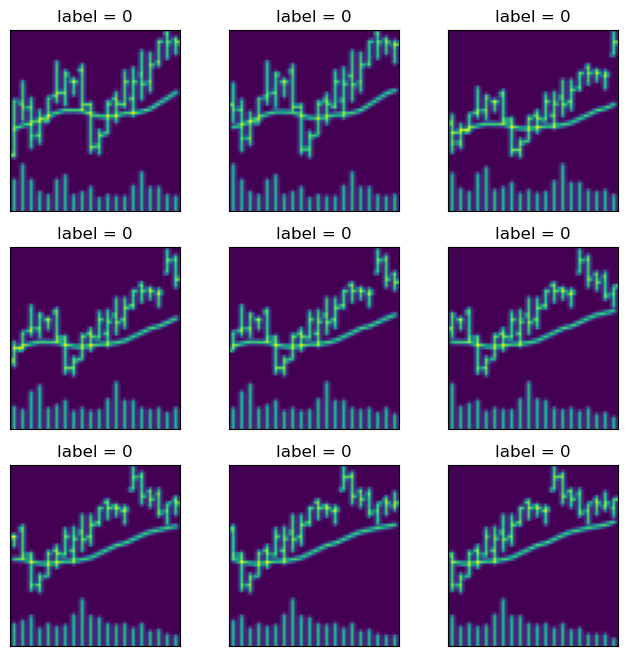

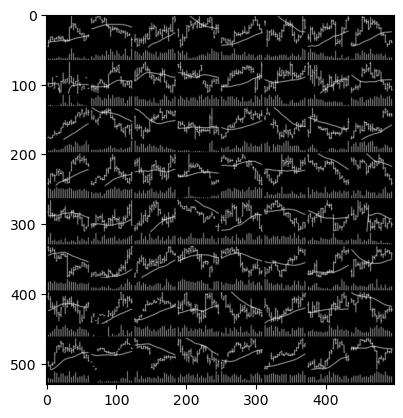

In [3]:
for features,labels in dl:
    print(features.shape)
    print(labels.shape)
    break

plt.figure(figsize=(8,8)) 
for i in range(1,10):
    img,label = ds[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

for i, data in enumerate(dl):
    images, labels = data

    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
 
    break

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnnStack = nn.Sequential(
            nn.Conv2d(1, 64, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),
            
            nn.Conv2d(128, 256, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),

            nn.Flatten(),
            nn.Linear(122880, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.cnnStack(x)

model = NeuralNetwork().to(device)

In [5]:
def two_hot(y):
    label = []
    for i in range(len(y)):
        if y[i]==1:
            label.append([1,0])
        else:
            label.append([0,1])
    return torch.Tensor(label).to(device)
    
loss_fn = nn.CrossEntropyLoss()
def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = two_hot(y)
        pred = model(X)
        #print(pred,y)
        loss = loss_fn(pred, y)
        #print(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        '''
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        '''
    return loss.item()

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = two_hot(y)
            test_loss += loss_fn(pred, y)
            pred = pred[:,0].ge(0.5)
            y = y[:,0].le(0.5)
            #print(pred,y)
            correct += (pred == y).sum().item()
            
    test_loss /= len(dataloader.dataset)
    #print(f"Average Loss: {test_loss:>7f} Accuracy: {int(correct / len(dataloader.dataset) * 100)}%")
    return test_loss.item(), correct / len(dataloader.dataset)

In [7]:
epochs = 1000
result = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    if(t<30):
        lr = 0.01
    else:
        lr = (epochs-t)/epochs*0.1
    
    optimizer = torch.optim.ASGD(model.parameters(), lr = lr)
    train_loss = train(dl_train, model, loss_fn, optimizer)
    test_loss, curr = test(dl_valid, model, loss_fn)
    print([t, lr, train_loss, test_loss, curr])
    result.append([t, lr, train_loss, test_loss, curr])
    if(t%10 == 0):
        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/kaggle/working/chkpt'+str(t)+'.pt')
        torch.save(result,'/kaggle/working/result'+str(t)+'.pt')
print("Done!")

[0, 0.01, 0.6894819140434265, 0.010775978676974773, 0.45735985067902424]


[1, 0.01, 0.7198734283447266, 0.010760084725916386, 0.4567162257836133]


[2, 0.01, 0.7119177579879761, 0.010752647183835506, 0.457166763210401]


[3, 0.01, 0.6816942095756531, 0.010749656707048416, 0.454463538649675]


[4, 0.01, 0.6851890087127686, 0.010759635828435421, 0.4567162257836133]


[5, 0.01, 0.6928240656852722, 0.010752611793577671, 0.45484971358692156]


[6, 0.01, 0.690339982509613, 0.010756001807749271, 0.45304756387977085]


[7, 0.01, 0.6773020029067993, 0.010746453888714314, 0.45221085151573664]


[8, 0.01, 0.6890436410903931, 0.010745924897491932, 0.45484971358692156]


[9, 0.01, 0.6743435263633728, 0.01074567437171936, 0.4540130012228873]


[10, 0.01, 0.687896192073822, 0.010745381005108356, 0.4527257514320654]


[11, 0.01, 0.6811589002609253, 0.010747266933321953, 0.45188903906803113]


[12, 0.01, 0.6674332022666931, 0.010744277387857437, 0.4526613889425243]


[13, 0.01, 0.6867219805717468, 0.010748283937573433, 0.45343373881701743]


[14, 0.01, 0.6701147556304932, 0.010745493695139885, 0.45452790113921604]


[15, 0.01, 0.7214871048927307, 0.010765249840915203, 0.46025616270837355]


[16, 0.01, 0.6592257022857666, 0.010751565918326378, 0.45356246379609966]


[17, 0.01, 0.6707242131233215, 0.010740043595433235, 0.4527901139216065]


[18, 0.01, 0.636475145816803, 0.010743669234216213, 0.4525326639634421]


[19, 0.01, 0.6884326934814453, 0.010747747495770454, 0.4522752140052777]


[20, 0.01, 0.6955867409706116, 0.010765880346298218, 0.4579391130848941]


[21, 0.01, 0.7233312726020813, 0.010744637809693813, 0.45349810130655854]


[22, 0.01, 0.6632453203201294, 0.010741977021098137, 0.4536268262856407]


[23, 0.01, 0.6726700067520142, 0.010736609809100628, 0.4538842762438051]


[24, 0.01, 0.6899998784065247, 0.01073545403778553, 0.4531762888588531]


[25, 0.01, 0.6783117055892944, 0.01074320450425148, 0.4525326639634421]


[26, 0.01, 0.6619524359703064, 0.010733060538768768, 0.4510523267039969]


[27, 0.01, 0.6780166625976562, 0.010731025598943233, 0.4529832013902298]


[28, 0.01, 0.6526941657066345, 0.010766246356070042, 0.45188903906803113]


[29, 0.01, 0.6742464303970337, 0.010739064775407314, 0.45394863873334623]


[30, 0.097, 0.7091374397277832, 0.010887705720961094, 0.48870438308553776]


[31, 0.0969, 0.6783032417297363, 0.010774599388241768, 0.45896891291755165]


[32, 0.0968, 0.6718187928199768, 0.01073732040822506, 0.45027997682950377]


[33, 0.09670000000000001, 0.7048727869987488, 0.010856942273676395, 0.4697174486709146]


[34, 0.0966, 0.6635573506355286, 0.010882769711315632, 0.45285447641114757]


[35, 0.0965, 0.6067134141921997, 0.01101519912481308, 0.453819913754264]


[36, 0.0964, 0.6993333697319031, 0.010844873264431953, 0.46334556220634615]


[37, 0.0963, 0.6105889678001404, 0.010838429443538189, 0.4601274377292914]


[38, 0.09620000000000001, 0.5438887476921082, 0.010919040068984032, 0.4564587758254489]


[39, 0.0961, 0.7252873182296753, 0.011036538518965244, 0.4683014739010105]


[40, 0.096, 0.7315676212310791, 0.011159932240843773, 0.4765398725622707]


[41, 0.0959, 0.7191475629806519, 0.010924886912107468, 0.4412048658042093]


[42, 0.0958, 0.63246089220047, 0.010997893288731575, 0.44738366480015446]


[43, 0.09570000000000001, 0.5809114575386047, 0.01113001350313425, 0.4553002510137092]


[44, 0.0956, 0.7001884579658508, 0.01127499621361494, 0.4653407993821201]


[45, 0.0955, 0.5727306008338928, 0.011149651370942593, 0.44802728969556543]


[46, 0.0954, 0.5709633231163025, 0.011296845972537994, 0.45182467657849007]


[47, 0.0953, 0.4958806037902832, 0.011264517903327942, 0.4455815150930038]


[48, 0.0952, 0.44486045837402344, 0.010999021120369434, 0.4286541803436957]


[49, 0.0951, 0.5229113698005676, 0.011159401386976242, 0.4361202291304628]


[50, 0.095, 0.528528094291687, 0.01100802980363369, 0.4232477312222437]


[51, 0.0949, 0.5678406953811646, 0.011108622886240482, 0.42659458067838063]


[52, 0.0948, 0.4820515811443329, 0.01108900923281908, 0.4272382055737916]


[53, 0.0947, 0.3850727677345276, 0.01111797709017992, 0.4245993435026067]


[54, 0.0946, 0.43312254548072815, 0.011122142896056175, 0.4242131685653601]


[55, 0.0945, 0.45020148158073425, 0.011020037345588207, 0.42073759413014095]


[56, 0.0944, 0.41120806336402893, 0.011035354807972908, 0.41681148226813414]


[57, 0.0943, 0.4247817397117615, 0.01107288058847189, 0.41945034433931905]


[58, 0.0942, 0.38135746121406555, 0.011175639927387238, 0.4269807556156272]


[59, 0.0941, 0.3402000665664673, 0.0109827546402812, 0.4131428203642917]


[60, 0.094, 0.38154837489128113, 0.01113207545131445, 0.42073759413014095]


[61, 0.0939, 0.3163881003856659, 0.011005599051713943, 0.40947415846044927]


[62, 0.0938, 0.37155309319496155, 0.011097674258053303, 0.42009396923473]


[63, 0.0937, 0.34980708360671997, 0.011022503487765789, 0.4131428203642917]


[64, 0.09360000000000002, 0.3144496977329254, 0.011021480895578861, 0.4130140953852095]


[65, 0.09350000000000001, 0.3489362895488739, 0.010998427867889404, 0.4090879835232027]


[66, 0.09340000000000001, 0.35047319531440735, 0.010995514690876007, 0.41095449571989445]


[67, 0.09330000000000001, 0.3828386068344116, 0.010991855524480343, 0.40921670850228486]


[68, 0.0932, 0.3137061893939972, 0.011000079102814198, 0.40934543348136704]


[69, 0.09310000000000002, 0.3140862286090851, 0.011011338792741299, 0.4084443586277917]


[70, 0.09300000000000001, 0.31351155042648315, 0.01100593525916338, 0.40934543348136704]


[71, 0.09290000000000001, 0.34856846928596497, 0.01105691771954298, 0.4132715453433739]


[72, 0.09280000000000001, 0.34795063734054565, 0.011020148172974586, 0.4112763081675999]


[73, 0.0927, 0.31388792395591736, 0.011014307849109173, 0.41089013323035334]


[74, 0.09260000000000002, 0.3136502504348755, 0.011021177284419537, 0.40966724592907255]


[75, 0.09250000000000001, 0.3137723505496979, 0.011012465693056583, 0.4087018085859561]


[76, 0.09240000000000001, 0.34801575541496277, 0.011023026891052723, 0.4115981206153054]


[77, 0.09230000000000001, 0.38268715143203735, 0.011018925346434116, 0.4103752333140246]


[78, 0.0922, 0.3480600118637085, 0.011011304333806038, 0.411340670657141]


[79, 0.09210000000000002, 0.3483606278896332, 0.011003110557794571, 0.4101177833558602]


[80, 0.09200000000000001, 0.3480991721153259, 0.01100955531001091, 0.4097316084186136]


[81, 0.09190000000000001, 0.3138219118118286, 0.011010948568582535, 0.410632683272189]


[82, 0.0918, 0.3141455054283142, 0.011015846394002438, 0.40966724592907255]


[83, 0.0917, 0.3139417767524719, 0.011017540469765663, 0.4116624831048465]


[84, 0.09160000000000001, 0.3137049078941345, 0.011012735776603222, 0.41204865804209306]


[85, 0.09150000000000001, 0.3827463686466217, 0.011016806587576866, 0.4119199330630109]


[86, 0.09140000000000001, 0.3483610451221466, 0.011018811725080013, 0.41217738302117524]


[87, 0.0913, 0.4168493449687958, 0.011017438024282455, 0.4114050331466821]


[88, 0.0912, 0.31413546204566956, 0.011019386351108551, 0.41249919546888075]


[89, 0.09110000000000001, 0.31389492750167847, 0.011017502285540104, 0.4121130205316342]


[90, 0.09100000000000001, 0.31365540623664856, 0.011017881333827972, 0.4125635579584218]


[91, 0.09090000000000001, 0.417151540517807, 0.011011466383934021, 0.4128210079165862]


[92, 0.0908, 0.34841009974479675, 0.011024907231330872, 0.4132071828538328]


[93, 0.0907, 0.34823113679885864, 0.011025536805391312, 0.41488060758190126]


[94, 0.09060000000000001, 0.31398898363113403, 0.01101323589682579, 0.41378644525970265]


[95, 0.09050000000000001, 0.3483256697654724, 0.011020610108971596, 0.4134646328119972]


[96, 0.09040000000000001, 0.3138291835784912, 0.011010654270648956, 0.4123704704897985]


[97, 0.0903, 0.3139234483242035, 0.011026492342352867, 0.414687520113278]


[98, 0.0902, 0.3142952620983124, 0.011016808450222015, 0.41333590783291496]


[99, 0.09010000000000001, 0.3835563659667969, 0.011011132039129734, 0.4132715453433739]


[100, 0.09000000000000001, 0.31431880593299866, 0.011008325032889843, 0.4131428203642917]


[101, 0.08990000000000001, 0.34818485379219055, 0.01101258210837841, 0.4131428203642917]


[102, 0.0898, 0.4172366261482239, 0.011006058193743229, 0.41352899530153825]


[103, 0.0897, 0.3140886127948761, 0.011015744879841805, 0.41288537040612733]


[104, 0.08960000000000001, 0.3486774265766144, 0.011001464910805225, 0.4131428203642917]


[105, 0.08950000000000001, 0.34828314185142517, 0.011020469479262829, 0.4132071828538328]


[106, 0.08940000000000001, 0.3140994608402252, 0.011017912067472935, 0.41352899530153825]


[107, 0.0893, 0.31410717964172363, 0.011015601456165314, 0.4130784578747506]


[108, 0.0892, 0.3138796091079712, 0.011000118218362331, 0.41101885820943557]


[109, 0.08910000000000001, 0.3826708495616913, 0.011005704291164875, 0.41198429555255195]


[110, 0.08900000000000001, 0.3141002655029297, 0.011014274321496487, 0.41288537040612733]


[111, 0.0889, 0.3144535422325134, 0.011006377637386322, 0.4132715453433739]


[112, 0.0888, 0.3831033706665039, 0.011009100824594498, 0.4130784578747506]


[113, 0.0887, 0.34832724928855896, 0.011008236557245255, 0.41204865804209306]


[114, 0.08860000000000001, 0.3288184702396393, 0.011044108308851719, 0.41951470682886016]


[115, 0.08850000000000001, 0.3486882448196411, 0.011075934395194054, 0.4217030314732574]


[116, 0.0884, 0.3392970561981201, 0.011045796796679497, 0.41687584475767525]


[117, 0.0883, 0.33537134528160095, 0.010989775881171227, 0.4132071828538328]


[118, 0.0882, 0.3169800937175751, 0.010969189926981926, 0.40831563364870954]


[119, 0.08810000000000001, 0.31661251187324524, 0.010944745503365993, 0.40921670850228486]


[120, 0.08800000000000001, 0.3486514985561371, 0.010957160033285618, 0.408637446096415]


[121, 0.0879, 0.3142601251602173, 0.010964618064463139, 0.40940979597090815]


[122, 0.0878, 0.34853020310401917, 0.010968301445245743, 0.41069704576173005]


[123, 0.0877, 0.3136032223701477, 0.010963942855596542, 0.40792945871146297]


[124, 0.08760000000000001, 0.313578724861145, 0.010987850837409496, 0.4114050331466821]


[125, 0.08750000000000001, 0.3137040436267853, 0.010971453040838242, 0.408637446096415]


[126, 0.0874, 0.34814536571502686, 0.010978114791214466, 0.40940979597090815]


[127, 0.0873, 0.31370192766189575, 0.010975513607263565, 0.409281070991826]


[128, 0.0872, 0.34830665588378906, 0.010982110165059566, 0.40947415846044927]


[129, 0.08710000000000001, 0.3135174512863159, 0.011000104248523712, 0.4103752333140246]


[130, 0.08700000000000001, 0.34841662645339966, 0.010975448414683342, 0.40818690866962737]


[131, 0.0869, 0.3483904004096985, 0.010989380069077015, 0.4101177833558602]


[132, 0.0868, 0.3483743667602539, 0.010977585799992085, 0.4110832206989766]


[133, 0.0867, 0.31370896100997925, 0.010985439643263817, 0.41121194567805885]


[134, 0.08660000000000001, 0.3138314485549927, 0.010991882532835007, 0.41204865804209306]


[135, 0.08650000000000001, 0.3138110041618347, 0.01099528931081295, 0.4117268455943876]


[136, 0.0864, 0.31389057636260986, 0.010986312292516232, 0.41179120808392866]


[137, 0.0863, 0.31375160813331604, 0.01098625361919403, 0.4112763081675999]


[138, 0.0862, 0.3139382302761078, 0.010988939553499222, 0.41095449571989445]


[139, 0.08610000000000001, 0.31388238072395325, 0.010988890193402767, 0.41230610800025747]


[140, 0.08600000000000001, 0.3138585686683655, 0.010992479510605335, 0.41269228293750404]


[141, 0.0859, 0.34833571314811707, 0.01098850928246975, 0.4114050331466821]


[142, 0.0858, 0.3139984607696533, 0.010999172925949097, 0.41352899530153825]


[143, 0.0857, 0.3485848605632782, 0.010989864356815815, 0.4130140953852095]


[144, 0.08560000000000001, 0.3487689197063446, 0.011000338941812515, 0.41404389521786705]


[145, 0.0855, 0.31396135687828064, 0.010992036201059818, 0.4134646328119972]


[146, 0.0854, 0.31411024928092957, 0.01099870540201664, 0.41378644525970265]


[147, 0.0853, 0.31396520137786865, 0.010992424562573433, 0.4130140953852095]


[148, 0.0852, 0.34867122769355774, 0.01099616289138794, 0.4132071828538328]


[149, 0.08510000000000001, 0.31429603695869446, 0.010990866459906101, 0.41269228293750404]


[150, 0.085, 0.31425154209136963, 0.010998735204339027, 0.41352899530153825]


[151, 0.0849, 0.3832763135433197, 0.010995125398039818, 0.4147518826028191]


[152, 0.0848, 0.34850600361824036, 0.010989496484398842, 0.4128210079165862]


[153, 0.0847, 0.34815311431884766, 0.010995478369295597, 0.4134002703224561]


[154, 0.08460000000000001, 0.3143044114112854, 0.010993776842951775, 0.4130784578747506]


[155, 0.0845, 0.31413987278938293, 0.010988008230924606, 0.41114758318851774]


[156, 0.0844, 0.3831464946269989, 0.010987420566380024, 0.4117268455943876]


[157, 0.0843, 0.31413671374320984, 0.010992712341248989, 0.41095449571989445]


[158, 0.0842, 0.31388676166534424, 0.010996917262673378, 0.4130140953852095]


[159, 0.08410000000000001, 0.3485528528690338, 0.010998872108757496, 0.4130140953852095]


[160, 0.084, 0.3140641748905182, 0.010982310399413109, 0.41121194567805885]


[161, 0.0839, 0.31420379877090454, 0.010991659946739674, 0.4136577202806205]


[162, 0.0838, 0.3585413098335266, 0.011286038905382156, 0.4381798287957778]


[163, 0.0837, 0.3683737814426422, 0.010907365940511227, 0.40374589689129176]


[164, 0.08360000000000001, 0.35256457328796387, 0.01094910316169262, 0.4131428203642917]


[165, 0.0835, 0.31921812891960144, 0.010982136242091656, 0.4128210079165862]


[166, 0.0834, 0.3484232723712921, 0.010898606851696968, 0.4057411340670657]


[167, 0.0833, 0.3146430552005768, 0.01090946327894926, 0.4055480465984424]


[168, 0.0832, 0.3139818012714386, 0.010880125686526299, 0.4014288472678123]


[169, 0.08310000000000001, 0.38254064321517944, 0.010900243185460567, 0.4036171719122096]


[170, 0.083, 0.34803009033203125, 0.01091733667999506, 0.40438952178670273]


[171, 0.0829, 0.31372326612472534, 0.010912315919995308, 0.4047113342344082]


[172, 0.0828, 0.34815162420272827, 0.010912829078733921, 0.4046469717448671]


[173, 0.0827, 0.38241520524024963, 0.010921506211161613, 0.40548368410890134]


[174, 0.0826, 0.31369805335998535, 0.010929353535175323, 0.40548368410890134]


[175, 0.0825, 0.3480320870876312, 0.010936515405774117, 0.407285833816052]


[176, 0.0824, 0.34810614585876465, 0.010935244150459766, 0.4067065714101821]


[177, 0.0823, 0.31365689635276794, 0.010934634134173393, 0.4061916714938534]


[178, 0.0822, 0.313623309135437, 0.01093877200037241, 0.4058698590461479]


[179, 0.0821, 0.31391388177871704, 0.010944083333015442, 0.4084443586277917]


[180, 0.082, 0.31368088722229004, 0.010949130170047283, 0.4076076462637575]


[181, 0.0819, 0.3136734068393707, 0.010939251631498337, 0.4064491214520178]


[182, 0.0818, 0.31368327140808105, 0.010949076153337955, 0.407285833816052]


[183, 0.0817, 0.31396666169166565, 0.010938181541860104, 0.4076076462637575]


[184, 0.0816, 0.3136966824531555, 0.01094009168446064, 0.40696402136834653]


[185, 0.0815, 0.31386029720306396, 0.010938207618892193, 0.40812254618008625]


[186, 0.0814, 0.3136851489543915, 0.010947545990347862, 0.4074789212846753]


[187, 0.0813, 0.3137667179107666, 0.010949093848466873, 0.40818690866962737]


[188, 0.08120000000000001, 0.3142073452472687, 0.010953730903565884, 0.4097959709081547]


[189, 0.0811, 0.34829041361808777, 0.010953912511467934, 0.4087018085859561]


[190, 0.08100000000000002, 0.3139466345310211, 0.010944356210529804, 0.4090879835232027]


[191, 0.08090000000000001, 0.348891019821167, 0.010956776328384876, 0.4099246958872369]


[192, 0.08080000000000001, 0.31374362111091614, 0.010962302796542645, 0.408637446096415]


[193, 0.08070000000000001, 0.38294151425361633, 0.010957601480185986, 0.409281070991826]


[194, 0.0806, 0.38315802812576294, 0.010964548215270042, 0.40947415846044927]


[195, 0.08050000000000002, 0.3143978714942932, 0.010948018170893192, 0.4087661710754972]


[196, 0.08040000000000001, 0.4172486960887909, 0.010960356332361698, 0.40921670850228486]


[197, 0.08030000000000001, 0.34861162304878235, 0.010963387787342072, 0.409989058376778]


[198, 0.08020000000000001, 0.38275739550590515, 0.010962818749248981, 0.4105683207826479]


[199, 0.0801, 0.3142331540584564, 0.01096844021230936, 0.4103108708244835]


[200, 0.08000000000000002, 0.3141276240348816, 0.01096255611628294, 0.4097316084186136]


[201, 0.07990000000000001, 0.3487882912158966, 0.010959243401885033, 0.4088948960545794]


[202, 0.07980000000000001, 0.3136559724807739, 0.01096114981919527, 0.40960288343953144]


[203, 0.07970000000000001, 0.34860315918922424, 0.010947546921670437, 0.40786509622192185]


[204, 0.0796, 0.3137005567550659, 0.010957065969705582, 0.40966724592907255]


[205, 0.07950000000000002, 0.314041405916214, 0.01095499936491251, 0.40934543348136704]


[206, 0.07940000000000001, 0.3482716679573059, 0.010966113768517971, 0.4097959709081547]


[207, 0.07930000000000001, 0.31455105543136597, 0.010958842001855373, 0.4088948960545794]


[208, 0.0792, 0.3141593337059021, 0.010959849692881107, 0.40895925854412046]


[209, 0.0791, 0.3141942322254181, 0.010971537791192532, 0.41050395829310676]


[210, 0.07900000000000001, 0.38330256938934326, 0.010955237783491611, 0.4090879835232027]


[211, 0.07890000000000001, 0.34880366921424866, 0.010966120287775993, 0.41089013323035334]


[212, 0.07880000000000001, 0.3140595555305481, 0.01095771323889494, 0.4088948960545794]


[213, 0.0787, 0.3485710620880127, 0.010954054072499275, 0.40947415846044927]


[214, 0.0786, 0.3143000900745392, 0.010952972806990147, 0.4084443586277917]


[215, 0.07850000000000001, 0.3831048309803009, 0.010958979837596416, 0.41076140825127117]


[216, 0.07840000000000001, 0.31434884667396545, 0.010959388688206673, 0.40940979597090815]


[217, 0.07830000000000001, 0.34856513142585754, 0.010972137562930584, 0.4104395958035657]


[218, 0.0782, 0.34853610396385193, 0.010953975841403008, 0.4090879835232027]


[219, 0.0781, 0.3142492473125458, 0.010956858284771442, 0.4090236210336616]


[220, 0.07800000000000001, 0.31383901834487915, 0.010947179980576038, 0.40818690866962737]


[221, 0.07790000000000001, 0.5030572414398193, 0.011597122065722942, 0.45723112569994206]


[222, 0.07780000000000001, 0.3436771333217621, 0.010989658534526825, 0.41681148226813414]


[223, 0.0777, 0.32312920689582825, 0.010909734293818474, 0.4076076462637575]


[224, 0.0776, 0.3177821636199951, 0.010924944654107094, 0.41198429555255195]


[225, 0.07750000000000001, 0.31465616822242737, 0.010960790328681469, 0.41269228293750404]


[226, 0.07740000000000001, 0.3138444125652313, 0.010921606793999672, 0.4074145587951342]


[227, 0.07730000000000001, 0.348162978887558, 0.01093163713812828, 0.4074789212846753]


[228, 0.0772, 0.3136039674282074, 0.010947172529995441, 0.4085730836068739]


[229, 0.0771, 0.3139837980270386, 0.010954903438687325, 0.4095385209499903]


[230, 0.07700000000000001, 0.31415536999702454, 0.01095667202025652, 0.4085730836068739]


[231, 0.07690000000000001, 0.31366032361984253, 0.01095498539507389, 0.4097316084186136]


[232, 0.07680000000000001, 0.34815096855163574, 0.010961937718093395, 0.4090236210336616]


[233, 0.0767, 0.34833991527557373, 0.010958805680274963, 0.4087018085859561]


[234, 0.0766, 0.313444584608078, 0.010954038240015507, 0.4084443586277917]


[235, 0.07650000000000001, 0.31380465626716614, 0.01095921453088522, 0.4088948960545794]


[236, 0.07640000000000001, 0.31363585591316223, 0.010960828512907028, 0.40850872111733283]


[237, 0.0763, 0.31363117694854736, 0.010960702784359455, 0.4097316084186136]


[238, 0.0762, 0.3136815130710602, 0.010963313281536102, 0.40960288343953144]


[239, 0.0761, 0.31383535265922546, 0.01096381526440382, 0.4088305335650383]


[240, 0.07600000000000001, 0.3830271065235138, 0.010964683257043362, 0.4104395958035657]


[241, 0.07590000000000001, 0.31397971510887146, 0.010967622511088848, 0.409989058376778]


[242, 0.0758, 0.31391581892967224, 0.010966378264129162, 0.4097959709081547]


[243, 0.0757, 0.3482515513896942, 0.010968955233693123, 0.40934543348136704]


[244, 0.0756, 0.3139852285385132, 0.010966641828417778, 0.4104395958035657]


[245, 0.07550000000000001, 0.31374624371528625, 0.010965106077492237, 0.40947415846044927]


[246, 0.07540000000000001, 0.3480098843574524, 0.01096460409462452, 0.4101177833558602]


[247, 0.0753, 0.31363797187805176, 0.010959018021821976, 0.408637446096415]


[248, 0.0752, 0.31386443972587585, 0.010968963615596294, 0.40986033339769584]


[249, 0.0751, 0.313805490732193, 0.010956469923257828, 0.40895925854412046]


[250, 0.07500000000000001, 0.34838899970054626, 0.010959579609334469, 0.40960288343953144]


[251, 0.07490000000000001, 0.31378844380378723, 0.010970463044941425, 0.4095385209499903]


[252, 0.0748, 0.3827909529209137, 0.010963833890855312, 0.4088948960545794]


[253, 0.0747, 0.3139623701572418, 0.01096235029399395, 0.4103752333140246]


[254, 0.0746, 0.31375792622566223, 0.010964022018015385, 0.41005342086631913]


[255, 0.0745, 0.3826175630092621, 0.010960500687360764, 0.40831563364870954]


[256, 0.07440000000000001, 0.3826965093612671, 0.010962441563606262, 0.408637446096415]


[257, 0.0743, 0.4172552824020386, 0.010964436456561089, 0.40940979597090815]


[258, 0.0742, 0.31382203102111816, 0.010960078798234463, 0.4085730836068739]


[259, 0.0741, 0.31412503123283386, 0.010970156639814377, 0.40947415846044927]


[260, 0.074, 0.3482493460178375, 0.01096702367067337, 0.40947415846044927]


[261, 0.07390000000000001, 0.3828188180923462, 0.010974250733852386, 0.4110832206989766]


[262, 0.0738, 0.3144940435886383, 0.010961038060486317, 0.40805818369054514]


[263, 0.0737, 0.41756826639175415, 0.010973546653985977, 0.41114758318851774]


[264, 0.0736, 0.38302701711654663, 0.010972772724926472, 0.4105683207826479]


[265, 0.0735, 0.3142745792865753, 0.01096569374203682, 0.40960288343953144]


[266, 0.0734, 0.31395360827445984, 0.010974506847560406, 0.4108257707408123]


[267, 0.0733, 0.31436124444007874, 0.010969668626785278, 0.4114050331466821]


[268, 0.0732, 0.3487628400325775, 0.01096128486096859, 0.41069704576173005]


[269, 0.0731, 0.3144086003303528, 0.010972586460411549, 0.4105683207826479]


[270, 0.073, 0.3483297526836395, 0.010958370752632618, 0.40986033339769584]


[271, 0.0729, 0.31397753953933716, 0.01096571609377861, 0.4095385209499903]


[272, 0.0728, 0.3143301010131836, 0.0109657421708107, 0.40921670850228486]


[273, 0.0727, 0.3141942620277405, 0.010963243432343006, 0.41050395829310676]


[274, 0.0726, 0.3831367492675781, 0.01096857339143753, 0.4105683207826479]


[275, 0.0725, 0.34700748324394226, 0.010956321842968464, 0.4103108708244835]


[276, 0.0724, 0.3441201448440552, 0.010927404277026653, 0.41095449571989445]


[277, 0.0723, 0.35642009973526, 0.010938294231891632, 0.40947415846044927]


[278, 0.0722, 0.349376380443573, 0.010901194997131824, 0.4073501963055931]


[279, 0.0721, 0.3145401179790497, 0.01090869028121233, 0.4057411340670657]


[280, 0.072, 0.3140932023525238, 0.010918277315795422, 0.405934221535689]


[281, 0.0719, 0.31394270062446594, 0.010921856388449669, 0.40541932161936023]


[282, 0.0718, 0.31370681524276733, 0.010930171236395836, 0.4071571088369698]


[283, 0.0717, 0.31397491693496704, 0.010936741717159748, 0.4075432837742164]


[284, 0.0716, 0.3137921988964081, 0.010943731293082237, 0.4068996588788054]


[285, 0.0715, 0.3138161599636078, 0.010933240875601768, 0.4078007337323808]


[286, 0.0714, 0.34824061393737793, 0.010939652100205421, 0.40664220892064107]


[287, 0.0713, 0.3137286603450775, 0.010950342752039433, 0.4074145587951342]


[288, 0.0712, 0.3480773866176605, 0.010953116230666637, 0.4079938212010041]


[289, 0.0711, 0.34814026951789856, 0.010949104093015194, 0.40818690866962737]


[290, 0.071, 0.31369155645370483, 0.010952104814350605, 0.4088948960545794]


[291, 0.0709, 0.3482849597930908, 0.010953173041343689, 0.40812254618008625]


[292, 0.0708, 0.34832826256752014, 0.0109564159065485, 0.40831563364870954]


[293, 0.0707, 0.31396228075027466, 0.010949880816042423, 0.4076076462637575]


[294, 0.0706, 0.3484107553958893, 0.010950959287583828, 0.4087661710754972]


[295, 0.0705, 0.3482666611671448, 0.010952838696539402, 0.4078007337323808]


[296, 0.0704, 0.31390583515167236, 0.010969530791044235, 0.4087661710754972]


[297, 0.0703, 0.3482058644294739, 0.010970145463943481, 0.40940979597090815]


[298, 0.0702, 0.3140500485897064, 0.010971548967063427, 0.40986033339769584]


[299, 0.0701, 0.3140128552913666, 0.01097014732658863, 0.4103752333140246]


[300, 0.06999999999999999, 0.3139607608318329, 0.01096526999026537, 0.40915234601274375]


[301, 0.0699, 0.31365087628364563, 0.010975753888487816, 0.41050395829310676]


[302, 0.0698, 0.34831559658050537, 0.010962426662445068, 0.4088305335650383]


[303, 0.0697, 0.3143767714500427, 0.010979460552334785, 0.41076140825127117]


[304, 0.0696, 0.31392380595207214, 0.010970444418489933, 0.4112763081675999]


[305, 0.06949999999999999, 0.31364014744758606, 0.010972901247441769, 0.4108257707408123]


[306, 0.0694, 0.31388360261917114, 0.010967706330120564, 0.410632683272189]


[307, 0.0693, 0.3139813542366028, 0.010970103554427624, 0.4102465083349424]


[308, 0.0692, 0.3140663802623749, 0.010968312621116638, 0.40986033339769584]


[309, 0.0691, 0.3140016794204712, 0.010978622362017632, 0.41076140825127117]


[310, 0.06899999999999999, 0.3486233353614807, 0.01097326073795557, 0.41095449571989445]


[311, 0.0689, 0.34838753938674927, 0.010963371954858303, 0.4097959709081547]


[312, 0.0688, 0.3137875497341156, 0.010966368950903416, 0.4105683207826479]


[313, 0.06870000000000001, 0.313919335603714, 0.01097154337912798, 0.4105683207826479]


[314, 0.06860000000000001, 0.3143765330314636, 0.010968152433633804, 0.41114758318851774]


[315, 0.0685, 0.31395477056503296, 0.010967899113893509, 0.40960288343953144]


[316, 0.0684, 0.31451448798179626, 0.010968465358018875, 0.4115981206153054]


[317, 0.06830000000000001, 0.31404903531074524, 0.010970177128911018, 0.4097316084186136]


[318, 0.06820000000000001, 0.31414639949798584, 0.01097159180790186, 0.41050395829310676]


[319, 0.06810000000000001, 0.31417378783226013, 0.010976926423609257, 0.41114758318851774]


[320, 0.068, 0.34870970249176025, 0.010972422547638416, 0.4114693956362232]


[321, 0.0679, 0.31393516063690186, 0.01097511500120163, 0.4119199330630109]


[322, 0.06780000000000001, 0.3140735924243927, 0.010968673042953014, 0.4114693956362232]


[323, 0.06770000000000001, 0.3141603171825409, 0.010974432341754436, 0.40986033339769584]


[324, 0.06760000000000001, 0.3140346109867096, 0.010974572971463203, 0.410632683272189]


[325, 0.0675, 0.3140723705291748, 0.010970027185976505, 0.4108257707408123]


[326, 0.0674, 0.3141933083534241, 0.010965202935039997, 0.41089013323035334]


[327, 0.06730000000000001, 0.3140046000480652, 0.010972687043249607, 0.41069704576173005]


[328, 0.06720000000000001, 0.3144117593765259, 0.010962284170091152, 0.409281070991826]


[329, 0.0671, 0.31411099433898926, 0.01098489761352539, 0.411340670657141]


[330, 0.067, 0.31415045261383057, 0.010975245386362076, 0.41076140825127117]


[331, 0.0669, 0.3140367269515991, 0.01097923330962658, 0.411340670657141]


[332, 0.06680000000000001, 0.3141033947467804, 0.010968634858727455, 0.41198429555255195]


[333, 0.06670000000000001, 0.47159886360168457, 0.011173013597726822, 0.42685203063654503]


[334, 0.0666, 0.36524686217308044, 0.010937530547380447, 0.41397953272832594]


[335, 0.0665, 0.4074553847312927, 0.010842615738511086, 0.40393898435991504]


[336, 0.0664, 0.31966280937194824, 0.011007439345121384, 0.4158460449250177]


[337, 0.06630000000000001, 0.34829002618789673, 0.010884608142077923, 0.4049687841925726]


[338, 0.06620000000000001, 0.34841644763946533, 0.010915008373558521, 0.4071571088369698]


[339, 0.0661, 0.3826405704021454, 0.010911469347774982, 0.40548368410890134]


[340, 0.066, 0.3137781322002411, 0.010930639691650867, 0.40664220892064107]


[341, 0.0659, 0.3480108976364136, 0.010932253673672676, 0.4051618716611959]


[342, 0.06580000000000001, 0.34807440638542175, 0.010938740335404873, 0.4070927463474287]


[343, 0.06570000000000001, 0.3137640357017517, 0.01095015462487936, 0.407285833816052]


[344, 0.0656, 0.31379279494285583, 0.010942758992314339, 0.4071571088369698]


[345, 0.0655, 0.3135283291339874, 0.01094744447618723, 0.4068996588788054]


[346, 0.0654, 0.31375399231910706, 0.010950418189167976, 0.40812254618008625]


[347, 0.06530000000000001, 0.3137555718421936, 0.01095788273960352, 0.4085730836068739]


[348, 0.06520000000000001, 0.31420260667800903, 0.01096337754279375, 0.40940979597090815]


[349, 0.0651, 0.3136497735977173, 0.010960330255329609, 0.4087018085859561]


[350, 0.065, 0.3137236535549164, 0.010977882891893387, 0.4116624831048465]


[351, 0.0649, 0.3482990264892578, 0.010960210114717484, 0.4102465083349424]


[352, 0.06480000000000001, 0.31376153230667114, 0.010965139605104923, 0.4090879835232027]


[353, 0.06470000000000001, 0.3484708368778229, 0.010965629480779171, 0.40915234601274375]


[354, 0.0646, 0.3482799530029297, 0.010965741239488125, 0.4090879835232027]


[355, 0.0645, 0.3139525353908539, 0.01096499152481556, 0.40850872111733283]


[356, 0.0644, 0.38279539346694946, 0.01097401138395071, 0.4102465083349424]


[357, 0.06430000000000001, 0.313888818025589, 0.010969314724206924, 0.409989058376778]


[358, 0.06420000000000001, 0.31431251764297485, 0.010972823947668076, 0.409989058376778]


[359, 0.0641, 0.34844768047332764, 0.010961960069835186, 0.40812254618008625]


[360, 0.064, 0.3483646512031555, 0.010964497923851013, 0.4097959709081547]


[361, 0.0639, 0.3139902353286743, 0.01097200345247984, 0.409281070991826]


[362, 0.06380000000000001, 0.34824857115745544, 0.010975045152008533, 0.4090236210336616]


[363, 0.0637, 0.3140143156051636, 0.010971740819513798, 0.4095385209499903]


[364, 0.0636, 0.31393560767173767, 0.01096219290047884, 0.4085730836068739]


[365, 0.0635, 0.3140314221382141, 0.01098046638071537, 0.41005342086631913]


[366, 0.0634, 0.34821265935897827, 0.010967522859573364, 0.4099246958872369]


[367, 0.06330000000000001, 0.3138691484928131, 0.01096896268427372, 0.4102465083349424]


[368, 0.0632, 0.31390953063964844, 0.010967873968183994, 0.4103108708244835]


[369, 0.0631, 0.31408560276031494, 0.010970297269523144, 0.4090236210336616]


[370, 0.063, 0.3136972486972809, 0.010966730304062366, 0.40818690866962737]


[371, 0.0629, 0.31404662132263184, 0.01097202580422163, 0.4101821458454013]


[372, 0.06280000000000001, 0.31439208984375, 0.010971403680741787, 0.41069704576173005]


[373, 0.0627, 0.31429699063301086, 0.010964218527078629, 0.4090236210336616]


[374, 0.0626, 0.3140713572502136, 0.010963170789182186, 0.4097316084186136]


[375, 0.0625, 0.34914588928222656, 0.010969270020723343, 0.4099246958872369]


[376, 0.062400000000000004, 0.31406718492507935, 0.010970214381814003, 0.4097316084186136]


[377, 0.0623, 0.3139648139476776, 0.010970077477395535, 0.40915234601274375]


[378, 0.062200000000000005, 0.348797082901001, 0.010963896289467812, 0.40960288343953144]


[379, 0.0621, 0.3138621151447296, 0.010957978665828705, 0.409989058376778]


[380, 0.062, 0.34858325123786926, 0.010979380458593369, 0.4104395958035657]


[381, 0.061900000000000004, 0.34833183884620667, 0.01098304707556963, 0.4114050331466821]


[382, 0.0618, 0.3482802212238312, 0.010977561585605145, 0.4115337581257643]


[383, 0.061700000000000005, 0.31449010968208313, 0.010998055338859558, 0.41230610800025747]


[384, 0.0616, 0.34858426451683044, 0.010987306013703346, 0.41269228293750404]


[385, 0.0615, 0.3486536145210266, 0.010981734842061996, 0.4110832206989766]


[386, 0.0614, 0.3487935960292816, 0.010989372618496418, 0.4139151702387848]


[387, 0.0613, 0.31388169527053833, 0.010980597697198391, 0.4115337581257643]


[388, 0.061200000000000004, 0.3142554759979248, 0.010965276509523392, 0.411340670657141]


[389, 0.0611, 0.3139931261539459, 0.010975086130201817, 0.411340670657141]


[390, 0.061, 0.31419438123703003, 0.010979089885950089, 0.4114050331466821]


[391, 0.0609, 0.3486213684082031, 0.010979785583913326, 0.41121194567805885]


[392, 0.0608, 0.38305407762527466, 0.010979041457176208, 0.4117268455943876]


[393, 0.060700000000000004, 0.34857237339019775, 0.010980681516230106, 0.41179120808392866]


[394, 0.0606, 0.31412893533706665, 0.01097082532942295, 0.41069704576173005]


[395, 0.0605, 0.31408876180648804, 0.010977623984217644, 0.4123704704897985]


[396, 0.0604, 0.3140852451324463, 0.010977445170283318, 0.4125635579584218]


[397, 0.0603, 0.31406381726264954, 0.010972927324473858, 0.4112763081675999]


[398, 0.060200000000000004, 0.34891173243522644, 0.010972472839057446, 0.4128210079165862]


[399, 0.0601, 0.4172370433807373, 0.010980095714330673, 0.4128210079165862]


[400, 0.06, 0.3143133521080017, 0.010974698700010777, 0.41179120808392866]


[401, 0.0599, 0.314201295375824, 0.010980314575135708, 0.41089013323035334]


[402, 0.0598, 0.34869077801704407, 0.010988139547407627, 0.4139151702387848]


[403, 0.0597, 0.40890729427337646, 0.011010359972715378, 0.41668275728905196]


[404, 0.0596, 0.335852712392807, 0.010913592763245106, 0.41076140825127117]


[405, 0.0595, 0.3171522319316864, 0.010966415517032146, 0.41526678251914784]


[406, 0.0594, 0.31603550910949707, 0.010898620821535587, 0.40509750917165477]


[407, 0.0593, 0.31448817253112793, 0.010905885137617588, 0.40696402136834653]


[408, 0.0592, 0.34836113452911377, 0.010939602740108967, 0.4070927463474287]


[409, 0.0591, 0.3143860101699829, 0.010948529466986656, 0.40786509622192185]


[410, 0.059, 0.3139406144618988, 0.010936979204416275, 0.40683529638926436]


[411, 0.0589, 0.3137619197368622, 0.010950804688036442, 0.4078007337323808]


[412, 0.0588, 0.3827008008956909, 0.01095199678093195, 0.40805818369054514]


[413, 0.0587, 0.3137561082839966, 0.010949534364044666, 0.4079938212010041]


[414, 0.0586, 0.31403276324272156, 0.010960446670651436, 0.40915234601274375]


[415, 0.058499999999999996, 0.3485083281993866, 0.010959413833916187, 0.4078007337323808]


[416, 0.0584, 0.3138841390609741, 0.01095957774668932, 0.4079938212010041]


[417, 0.0583, 0.38288137316703796, 0.010968429036438465, 0.4088948960545794]


[418, 0.0582, 0.31405556201934814, 0.010959314182400703, 0.4088305335650383]


[419, 0.0581, 0.3139730393886566, 0.010966871865093708, 0.40895925854412046]


[420, 0.057999999999999996, 0.3482707142829895, 0.010966343805193901, 0.40850872111733283]


[421, 0.0579, 0.34831830859184265, 0.010971581563353539, 0.40850872111733283]


[422, 0.0578, 0.3138014078140259, 0.010971475392580032, 0.4090236210336616]


[423, 0.0577, 0.3137788474559784, 0.010966259054839611, 0.4084443586277917]


[424, 0.0576, 0.31421512365341187, 0.010974565520882607, 0.40940979597090815]


[425, 0.057499999999999996, 0.3139442801475525, 0.01096651516854763, 0.4090236210336616]


[426, 0.0574, 0.3139861822128296, 0.010979542508721352, 0.4102465083349424]


[427, 0.0573, 0.31397247314453125, 0.010977080091834068, 0.4088948960545794]


[428, 0.0572, 0.3139162063598633, 0.010962987318634987, 0.4084443586277917]


[429, 0.0571, 0.34860050678253174, 0.010968982242047787, 0.40986033339769584]


[430, 0.056999999999999995, 0.3484009802341461, 0.010966339148581028, 0.4087018085859561]


[431, 0.0569, 0.31369781494140625, 0.010971090756356716, 0.40792945871146297]


[432, 0.056799999999999996, 0.31395432353019714, 0.010965246707201004, 0.40850872111733283]


[433, 0.0567, 0.31394365429878235, 0.01096945907920599, 0.4097959709081547]


[434, 0.0566, 0.3827776312828064, 0.01096265483647585, 0.4102465083349424]


[435, 0.056499999999999995, 0.3139995336532593, 0.01096752006560564, 0.41101885820943557]


[436, 0.0564, 0.31422150135040283, 0.01099400408565998, 0.4123704704897985]


[437, 0.056299999999999996, 0.34851500391960144, 0.010969099588692188, 0.4102465083349424]


[438, 0.05620000000000001, 0.31402069330215454, 0.01097218319773674, 0.4103752333140246]


[439, 0.05610000000000001, 0.3142744302749634, 0.010981176048517227, 0.4108257707408123]


[440, 0.05600000000000001, 0.3826977014541626, 0.01097876951098442, 0.4115337581257643]


[441, 0.055900000000000005, 0.31431546807289124, 0.010981306433677673, 0.41121194567805885]


[442, 0.05580000000000001, 0.3144114315509796, 0.010984997265040874, 0.4112763081675999]


[443, 0.055700000000000006, 0.3830609917640686, 0.01096704974770546, 0.41005342086631913]


[444, 0.05560000000000001, 0.382592111825943, 0.010982878506183624, 0.41101885820943557]


[445, 0.05550000000000001, 0.3485911786556244, 0.010969550348818302, 0.4112763081675999]


[446, 0.055400000000000005, 0.3139210343360901, 0.010969698429107666, 0.409989058376778]


[447, 0.05530000000000001, 0.31392616033554077, 0.010975631885230541, 0.4121130205316342]


[448, 0.055200000000000006, 0.31379884481430054, 0.01097790151834488, 0.411340670657141]


[449, 0.05510000000000001, 0.3139990568161011, 0.010972509160637856, 0.4103108708244835]


[450, 0.05500000000000001, 0.31379252672195435, 0.010971937328577042, 0.41095449571989445]


[451, 0.054900000000000004, 0.31411099433898926, 0.010976370424032211, 0.4115981206153054]


[452, 0.05480000000000001, 0.3485508859157562, 0.010978028178215027, 0.41095449571989445]


[453, 0.054700000000000006, 0.3141489028930664, 0.010976292192935944, 0.41179120808392866]


[454, 0.05460000000000001, 0.3140437602996826, 0.010980659164488316, 0.41204865804209306]


[455, 0.05450000000000001, 0.3831903636455536, 0.010984811931848526, 0.4119199330630109]


[456, 0.054400000000000004, 0.31394925713539124, 0.010955086909234524, 0.4087018085859561]


[457, 0.05430000000000001, 0.34861764311790466, 0.010982964187860489, 0.41269228293750404]


[458, 0.054200000000000005, 0.3481716215610504, 0.010961431078612804, 0.40960288343953144]


[459, 0.05410000000000001, 0.3140895366668701, 0.010985507629811764, 0.41249919546888075]


[460, 0.054000000000000006, 0.3486664891242981, 0.010978037491440773, 0.4118555705734698]


[461, 0.0539, 0.3485316336154938, 0.010966305620968342, 0.41101885820943557]


[462, 0.05380000000000001, 0.34860315918922424, 0.010972990654408932, 0.4114050331466821]


[463, 0.053700000000000005, 0.314169317483902, 0.010974904522299767, 0.41198429555255195]


[464, 0.05360000000000001, 0.314201295375824, 0.010989215224981308, 0.41404389521786705]


[465, 0.053500000000000006, 0.3140861988067627, 0.010974995791912079, 0.41204865804209306]


[466, 0.0534, 0.38224273920059204, 0.011079156771302223, 0.42208920641050396]


[467, 0.05330000000000001, 0.3547915518283844, 0.011046088300645351, 0.41951470682886016]


[468, 0.053200000000000004, 0.35031968355178833, 0.010941381566226482, 0.4118555705734698]


[469, 0.05310000000000001, 0.3151591122150421, 0.010931859724223614, 0.40915234601274375]


[470, 0.053000000000000005, 0.38299718499183655, 0.010945595800876617, 0.40934543348136704]


[471, 0.0529, 0.314189076423645, 0.010951605625450611, 0.4095385209499903]


[472, 0.05280000000000001, 0.34861814975738525, 0.010950691998004913, 0.40940979597090815]


[473, 0.052700000000000004, 0.3487001955509186, 0.01094958558678627, 0.40850872111733283]


[474, 0.05260000000000001, 0.3140404224395752, 0.010969975963234901, 0.41121194567805885]


[475, 0.052500000000000005, 0.3487510085105896, 0.010965569876134396, 0.4101821458454013]


[476, 0.0524, 0.41732653975486755, 0.010967196896672249, 0.41050395829310676]


[477, 0.052300000000000006, 0.31379562616348267, 0.010971630923449993, 0.41089013323035334]


[478, 0.0522, 0.3829110562801361, 0.010970392264425755, 0.4110832206989766]


[479, 0.05210000000000001, 0.3142140507698059, 0.010977886617183685, 0.410632683272189]


[480, 0.052000000000000005, 0.31394532322883606, 0.010973786935210228, 0.41095449571989445]


[481, 0.0519, 0.38302624225616455, 0.010974851436913013, 0.41089013323035334]


[482, 0.051800000000000006, 0.31397438049316406, 0.01096708420664072, 0.41005342086631913]


[483, 0.0517, 0.3485015034675598, 0.010981349274516106, 0.41230610800025747]


[484, 0.05160000000000001, 0.3137989640235901, 0.010978536680340767, 0.4116624831048465]


[485, 0.051500000000000004, 0.3140021860599518, 0.010978191159665585, 0.4119199330630109]


[486, 0.0514, 0.3483259975910187, 0.010981938801705837, 0.4127566454270451]


[487, 0.051300000000000005, 0.3139483332633972, 0.010977565310895443, 0.4112763081675999]


[488, 0.0512, 0.31415820121765137, 0.010982442647218704, 0.41217738302117524]


[489, 0.051100000000000007, 0.34843966364860535, 0.010986228473484516, 0.41230610800025747]


[490, 0.051000000000000004, 0.3141953945159912, 0.010985360480844975, 0.4118555705734698]


[491, 0.0509, 0.34838148951530457, 0.010979647748172283, 0.4116624831048465]


[492, 0.050800000000000005, 0.3139289319515228, 0.010986654087901115, 0.4128210079165862]


[493, 0.0507, 0.3139849007129669, 0.010986647568643093, 0.4121130205316342]


[494, 0.050600000000000006, 0.3827107548713684, 0.010985884815454483, 0.4121130205316342]


[495, 0.0505, 0.31442326307296753, 0.010978743433952332, 0.4114050331466821]


[496, 0.0504, 0.3140122592449188, 0.010972840711474419, 0.41198429555255195]


[497, 0.050300000000000004, 0.3486025929450989, 0.010992065072059631, 0.41243483297933964]


[498, 0.0502, 0.3139253854751587, 0.010981570929288864, 0.4112763081675999]


[499, 0.050100000000000006, 0.31393012404441833, 0.010977684520184994, 0.41198429555255195]


[500, 0.05, 0.38307854533195496, 0.010976925492286682, 0.411340670657141]


[501, 0.0499, 0.3142605423927307, 0.01097441092133522, 0.4114693956362232]


[502, 0.049800000000000004, 0.31424352526664734, 0.010981992818415165, 0.41069704576173005]


[503, 0.0497, 0.3137722611427307, 0.010981106199324131, 0.4112763081675999]


[504, 0.049600000000000005, 0.313772588968277, 0.01097844261676073, 0.41114758318851774]


[505, 0.0495, 0.31424838304519653, 0.010979759506881237, 0.4121130205316342]


[506, 0.0494, 0.3140186071395874, 0.010980446822941303, 0.4129497328956684]


[507, 0.049300000000000004, 0.31417667865753174, 0.010969942435622215, 0.41198429555255195]


[508, 0.0492, 0.34837183356285095, 0.010982458479702473, 0.4117268455943876]


[509, 0.049100000000000005, 0.313984215259552, 0.010978249832987785, 0.4117268455943876]


[510, 0.049, 0.314020574092865, 0.01098048035055399, 0.4118555705734698]


[511, 0.0489, 0.3141349256038666, 0.010989527218043804, 0.4130784578747506]


[512, 0.0488, 0.3140685558319092, 0.010987507179379463, 0.41230610800025747]


[513, 0.0487, 0.3139480650424957, 0.010977182537317276, 0.4112763081675999]


[514, 0.048600000000000004, 0.3485907316207886, 0.010980794206261635, 0.41204865804209306]


[515, 0.0485, 0.3485245406627655, 0.010985714383423328, 0.4126279204479629]


[516, 0.0484, 0.34849482774734497, 0.010973906144499779, 0.4101177833558602]


[517, 0.0483, 0.31407833099365234, 0.01098916120827198, 0.41204865804209306]


[518, 0.0482, 0.31428471207618713, 0.010981232859194279, 0.41217738302117524]


[519, 0.048100000000000004, 0.3484892249107361, 0.01097892690449953, 0.41069704576173005]


[520, 0.048, 0.31433120369911194, 0.010976042598485947, 0.41121194567805885]


[521, 0.0479, 0.31400439143180847, 0.010990740731358528, 0.4121130205316342]


[522, 0.0478, 0.31413552165031433, 0.010975472629070282, 0.4118555705734698]


[523, 0.0477, 0.3485456109046936, 0.010978179052472115, 0.41101885820943557]


[524, 0.0476, 0.3485819697380066, 0.010981779545545578, 0.41050395829310676]


[525, 0.0475, 0.3143996596336365, 0.01097564771771431, 0.41050395829310676]


[526, 0.0474, 0.3140311539173126, 0.010980293154716492, 0.4115981206153054]


[527, 0.0473, 0.31395697593688965, 0.010977399535477161, 0.4103752333140246]


[528, 0.0472, 0.3482230007648468, 0.010982916690409184, 0.411340670657141]


[529, 0.0471, 0.3140348792076111, 0.010980948805809021, 0.41179120808392866]


[530, 0.047, 0.3139486014842987, 0.010977338068187237, 0.4121130205316342]


[531, 0.0469, 0.314212441444397, 0.010982222855091095, 0.41224174551071635]


[532, 0.04680000000000001, 0.3140981197357178, 0.010983306914567947, 0.41095449571989445]


[533, 0.046700000000000005, 0.34847259521484375, 0.010984987951815128, 0.4131428203642917]


[534, 0.0466, 0.3827154338359833, 0.010983521118760109, 0.4112763081675999]


[535, 0.04650000000000001, 0.31435906887054443, 0.010985061526298523, 0.4114693956362232]


[536, 0.046400000000000004, 0.3140096664428711, 0.0109881442040205, 0.41179120808392866]


[537, 0.04630000000000001, 0.3485144376754761, 0.010981269180774689, 0.4105683207826479]


[538, 0.046200000000000005, 0.3485206067562103, 0.010995188727974892, 0.4115981206153054]


[539, 0.0461, 0.41747456789016724, 0.010972877964377403, 0.4101177833558602]


[540, 0.046000000000000006, 0.3140982389450073, 0.010972586460411549, 0.4114693956362232]


[541, 0.0459, 0.31393495202064514, 0.010999130085110664, 0.4112763081675999]


[542, 0.04580000000000001, 0.34858381748199463, 0.0109845707193017, 0.4112763081675999]


[543, 0.045700000000000005, 0.3484562933444977, 0.010984031483530998, 0.41230610800025747]


[544, 0.0456, 0.34853804111480713, 0.010979890823364258, 0.4112763081675999]


[545, 0.045500000000000006, 0.31401771306991577, 0.010985390283167362, 0.41217738302117524]


[546, 0.0454, 0.3138671815395355, 0.010989587754011154, 0.41217738302117524]


[547, 0.04530000000000001, 0.3139362931251526, 0.010981512255966663, 0.4128210079165862]


[548, 0.045200000000000004, 0.3484742045402527, 0.010984322987496853, 0.41269228293750404]


[549, 0.0451, 0.31433796882629395, 0.010983205400407314, 0.4121130205316342]


[550, 0.045000000000000005, 0.3141236901283264, 0.010988781228661537, 0.41089013323035334]


[551, 0.0449, 0.3140590786933899, 0.010974201373755932, 0.411340670657141]


[552, 0.044800000000000006, 0.3140581250190735, 0.010973460040986538, 0.41217738302117524]


[553, 0.044700000000000004, 0.31400272250175476, 0.010994859039783478, 0.41230610800025747]


[554, 0.0446, 0.31396234035491943, 0.01098345685750246, 0.4117268455943876]


[555, 0.044500000000000005, 0.34839585423469543, 0.010981122963130474, 0.4115337581257643]


[556, 0.0444, 0.3141430914402008, 0.01098328735679388, 0.411340670657141]


[557, 0.044300000000000006, 0.34861138463020325, 0.010980449616909027, 0.41179120808392866]


[558, 0.0442, 0.31419748067855835, 0.01098198164254427, 0.41179120808392866]


[559, 0.0441, 0.3485819101333618, 0.010977203026413918, 0.4114693956362232]


[560, 0.044000000000000004, 0.31413334608078003, 0.010978172533214092, 0.4114693956362232]


[561, 0.0439, 0.31405705213546753, 0.010981644503772259, 0.4110832206989766]


[562, 0.043800000000000006, 0.34861958026885986, 0.01097444724291563, 0.4104395958035657]


[563, 0.0437, 0.3140527009963989, 0.010991435497999191, 0.4128210079165862]


[564, 0.0436, 0.31412559747695923, 0.010977957397699356, 0.4118555705734698]


[565, 0.043500000000000004, 0.3140997588634491, 0.010972089134156704, 0.41101885820943557]


[566, 0.0434, 0.3484693765640259, 0.010976052843034267, 0.4114693956362232]


[567, 0.043300000000000005, 0.31426456570625305, 0.01097943540662527, 0.4103108708244835]


[568, 0.0432, 0.34864285588264465, 0.010984986089169979, 0.411340670657141]


[569, 0.0431, 0.3484798073768616, 0.010985489003360271, 0.41217738302117524]


[570, 0.043000000000000003, 0.3140287697315216, 0.010979191400110722, 0.4117268455943876]


[571, 0.0429, 0.3139234483242035, 0.010983128100633621, 0.4110832206989766]


[572, 0.042800000000000005, 0.31440669298171997, 0.010981638915836811, 0.41352899530153825]


[573, 0.0427, 0.31387269496917725, 0.010975276120007038, 0.41179120808392866]


[574, 0.0426, 0.31390562653541565, 0.010982031002640724, 0.4101821458454013]


[575, 0.0425, 0.31432783603668213, 0.010969086550176144, 0.410632683272189]


[576, 0.0424, 0.3142794966697693, 0.010976790450513363, 0.41076140825127117]


[577, 0.042300000000000004, 0.3483473062515259, 0.010978004895150661, 0.4129497328956684]


[578, 0.0422, 0.31416523456573486, 0.010986159555613995, 0.41288537040612733]


[579, 0.0421, 0.34849464893341064, 0.01097685843706131, 0.41269228293750404]


[580, 0.042, 0.31401345133781433, 0.010988837108016014, 0.4125635579584218]


[581, 0.0419, 0.3140692114830017, 0.010977997444570065, 0.41198429555255195]


[582, 0.041800000000000004, 0.31420162320137024, 0.010993363335728645, 0.4115981206153054]


[583, 0.0417, 0.31414100527763367, 0.010993016883730888, 0.4114693956362232]


[584, 0.0416, 0.313982218503952, 0.01098169106990099, 0.41095449571989445]


[585, 0.0415, 0.31410539150238037, 0.01096790749579668, 0.4102465083349424]


[586, 0.0414, 0.3142838180065155, 0.010988631285727024, 0.4115337581257643]


[587, 0.0413, 0.3486793637275696, 0.01097743958234787, 0.41076140825127117]


[588, 0.0412, 0.3146018385887146, 0.010975233279168606, 0.41121194567805885]


[589, 0.0411, 0.31444254517555237, 0.010982610285282135, 0.4121130205316342]


[590, 0.041, 0.3141865134239197, 0.010983447544276714, 0.4101821458454013]


[591, 0.0409, 0.3140874207019806, 0.010982288978993893, 0.4114693956362232]


[592, 0.0408, 0.3138611614704132, 0.010989109985530376, 0.4118555705734698]


[593, 0.0407, 0.3142271935939789, 0.010977336205542088, 0.4112763081675999]


[594, 0.040600000000000004, 0.313991516828537, 0.010991976596415043, 0.4131428203642917]


[595, 0.04050000000000001, 0.3140726387500763, 0.01098155602812767, 0.41269228293750404]


[596, 0.040400000000000005, 0.314169704914093, 0.010990024544298649, 0.4121130205316342]


[597, 0.0403, 0.3140674829483032, 0.010972910560667515, 0.4115981206153054]


[598, 0.04020000000000001, 0.3142210841178894, 0.010979533195495605, 0.41050395829310676]


[599, 0.040100000000000004, 0.38316693902015686, 0.010977930389344692, 0.4114050331466821]


[600, 0.04000000000000001, 0.31418830156326294, 0.010987321846187115, 0.4112763081675999]


[601, 0.039900000000000005, 0.3142203390598297, 0.010982437990605831, 0.4118555705734698]


[602, 0.0398, 0.3143227696418762, 0.01098854374140501, 0.41089013323035334]


[603, 0.039700000000000006, 0.3140594959259033, 0.010982380248606205, 0.4115981206153054]


[604, 0.0396, 0.382941871881485, 0.01098061166703701, 0.4114693956362232]


[605, 0.03950000000000001, 0.31390419602394104, 0.010976859368383884, 0.4114050331466821]


[606, 0.039400000000000004, 0.31437018513679504, 0.010980497114360332, 0.4116624831048465]


[607, 0.0393, 0.3144214153289795, 0.011009985581040382, 0.4130140953852095]


[608, 0.039200000000000006, 0.38319650292396545, 0.010977404192090034, 0.4114050331466821]


[609, 0.0391, 0.31383273005485535, 0.01098298467695713, 0.4115337581257643]


[610, 0.03900000000000001, 0.34862300753593445, 0.01098962314426899, 0.4110832206989766]


[611, 0.038900000000000004, 0.38292062282562256, 0.010990473441779613, 0.4115337581257643]


[612, 0.0388, 0.31409600377082825, 0.01097659207880497, 0.4125635579584218]


[613, 0.038700000000000005, 0.3486402630805969, 0.010990617796778679, 0.4114693956362232]


[614, 0.0386, 0.38292720913887024, 0.010980895720422268, 0.4121130205316342]


[615, 0.038500000000000006, 0.31428778171539307, 0.010988106019794941, 0.41121194567805885]


[616, 0.038400000000000004, 0.34852296113967896, 0.010989204980432987, 0.4119199330630109]


[617, 0.0383, 0.34870773553848267, 0.011002631857991219, 0.4132715453433739]


[618, 0.038200000000000005, 0.3141241669654846, 0.010990212671458721, 0.4114050331466821]


[619, 0.0381, 0.31442269682884216, 0.010984007269144058, 0.4116624831048465]


[620, 0.038000000000000006, 0.3829255998134613, 0.010990463197231293, 0.41089013323035334]


[621, 0.0379, 0.38336417078971863, 0.01098223589360714, 0.4118555705734698]


[622, 0.0378, 0.3484203815460205, 0.010990893468260765, 0.41101885820943557]


[623, 0.037700000000000004, 0.3486652076244354, 0.010982604697346687, 0.4115337581257643]


[624, 0.0376, 0.3140500783920288, 0.010988538153469563, 0.410632683272189]


[625, 0.037500000000000006, 0.31420761346817017, 0.010980821214616299, 0.41230610800025747]


[626, 0.0374, 0.31410738825798035, 0.010985523462295532, 0.41076140825127117]


[627, 0.0373, 0.3139929473400116, 0.010994588024914265, 0.41230610800025747]


[628, 0.037200000000000004, 0.31410396099090576, 0.010982728563249111, 0.410632683272189]


[629, 0.0371, 0.34842827916145325, 0.010994656942784786, 0.4121130205316342]


[630, 0.037, 0.34851977229118347, 0.010982317849993706, 0.41217738302117524]


[631, 0.0369, 0.34825751185417175, 0.010984670370817184, 0.4102465083349424]


[632, 0.0368, 0.31398358941078186, 0.010981866158545017, 0.41069704576173005]


[633, 0.0367, 0.3141104280948639, 0.010987440124154091, 0.4112763081675999]


[634, 0.0366, 0.34739866852760315, 0.01113500539213419, 0.42035141919289437]


[635, 0.0365, 0.37010955810546875, 0.010970145463943481, 0.414687520113278]


[636, 0.0364, 0.31731513142585754, 0.01091761328279972, 0.408637446096415]


[637, 0.0363, 0.3153427243232727, 0.01095591764897108, 0.4108257707408123]


[638, 0.0362, 0.3138059377670288, 0.010980954393744469, 0.4118555705734698]


[639, 0.0361, 0.31483203172683716, 0.010975135490298271, 0.41204865804209306]


[640, 0.036, 0.3485383689403534, 0.010985511355102062, 0.41372208277016154]


[641, 0.0359, 0.34882986545562744, 0.01099590677767992, 0.41288537040612733]


[642, 0.0358, 0.348443865776062, 0.0109980134293437, 0.4144300701551136]


[643, 0.0357, 0.34876373410224915, 0.01099730096757412, 0.4141726201969492]


[644, 0.0356, 0.3140568137168884, 0.010996274650096893, 0.4149449700714424]


[645, 0.0355, 0.34852784872055054, 0.010993211530148983, 0.41404389521786705]


[646, 0.0354, 0.3138379156589508, 0.010998648591339588, 0.41385080774924377]


[647, 0.0353, 0.3139984905719757, 0.010997562669217587, 0.414687520113278]


[648, 0.0352, 0.313696026802063, 0.011000515893101692, 0.41423698268649034]


[649, 0.0351, 0.3140467703342438, 0.011002499610185623, 0.4139151702387848]


[650, 0.034999999999999996, 0.31374526023864746, 0.010997310280799866, 0.4127566454270451]


[651, 0.0349, 0.38300806283950806, 0.011010256595909595, 0.41552423247731224]


[652, 0.0348, 0.3137076795101166, 0.011018701829016209, 0.41481624509236015]


[653, 0.0347, 0.3482043147087097, 0.011003141291439533, 0.4131428203642917]


[654, 0.0346, 0.31407108902931213, 0.011010789312422276, 0.41404389521786705]


[655, 0.034499999999999996, 0.38291576504707336, 0.011005859822034836, 0.4134646328119972]


[656, 0.0344, 0.3139921724796295, 0.011005914770066738, 0.4126279204479629]


[657, 0.034300000000000004, 0.3141328990459442, 0.01101323775947094, 0.41385080774924377]


[658, 0.0342, 0.34840813279151917, 0.011001932434737682, 0.4126279204479629]


[659, 0.034100000000000005, 0.31396248936653137, 0.011010813526809216, 0.4149449700714424]


[660, 0.034, 0.34841543436050415, 0.011006396263837814, 0.41269228293750404]


[661, 0.033900000000000007, 0.31393611431121826, 0.011003270745277405, 0.41243483297933964]


[662, 0.033800000000000004, 0.3482457101345062, 0.011005207896232605, 0.41217738302117524]


[663, 0.0337, 0.34840768575668335, 0.011004607193171978, 0.41230610800025747]


[664, 0.033600000000000005, 0.3137768507003784, 0.011004295200109482, 0.4114693956362232]


[665, 0.0335, 0.41721439361572266, 0.011014278046786785, 0.4132715453433739]


[666, 0.033400000000000006, 0.31411293148994446, 0.011012629605829716, 0.4136577202806205]


[667, 0.0333, 0.31419622898101807, 0.01100942213088274, 0.4123704704897985]


[668, 0.0332, 0.3138381242752075, 0.011008348315954208, 0.41333590783291496]


[669, 0.033100000000000004, 0.3141847550868988, 0.011010588146746159, 0.4139151702387848]


[670, 0.033, 0.31378164887428284, 0.01101111900061369, 0.41397953272832594]


[671, 0.032900000000000006, 0.31393635272979736, 0.011008067056536674, 0.4130140953852095]


[672, 0.0328, 0.31424522399902344, 0.011007177643477917, 0.4128210079165862]


[673, 0.0327, 0.31390565633773804, 0.011011266149580479, 0.41204865804209306]


[674, 0.032600000000000004, 0.31400471925735474, 0.011003597639501095, 0.4131428203642917]


[675, 0.0325, 0.3485070765018463, 0.011005152016878128, 0.4130784578747506]


[676, 0.032400000000000005, 0.3139810264110565, 0.011002459563314915, 0.4126279204479629]


[677, 0.0323, 0.31401321291923523, 0.011003495194017887, 0.4130140953852095]


[678, 0.0322, 0.3140008747577667, 0.011006857268512249, 0.41288537040612733]


[679, 0.032100000000000004, 0.34848299622535706, 0.011007190681993961, 0.41378644525970265]


[680, 0.032, 0.3144413232803345, 0.011014483869075775, 0.41204865804209306]


[681, 0.031900000000000005, 0.3141844570636749, 0.010998561047017574, 0.4117268455943876]


[682, 0.0318, 0.3139171898365021, 0.011014950461685658, 0.4144944326446547]


[683, 0.0317, 0.3485965132713318, 0.011008452624082565, 0.41243483297933964]


[684, 0.0316, 0.34840551018714905, 0.011008517816662788, 0.4132715453433739]


[685, 0.0315, 0.31429731845855713, 0.011002927087247372, 0.41224174551071635]


[686, 0.031400000000000004, 0.34837228059768677, 0.011004595085978508, 0.4139151702387848]


[687, 0.0313, 0.31385666131973267, 0.01101589109748602, 0.4132715453433739]


[688, 0.031200000000000002, 0.3140240013599396, 0.011016109958291054, 0.4132071828538328]


[689, 0.031100000000000003, 0.31369996070861816, 0.011008157394826412, 0.4132071828538328]


[690, 0.031, 0.3481452465057373, 0.011020345613360405, 0.4141726201969492]


[691, 0.0309, 0.31423601508140564, 0.011007328517735004, 0.4129497328956684]


[692, 0.0308, 0.3831212520599365, 0.01100740022957325, 0.4130784578747506]


[693, 0.0307, 0.313874751329422, 0.011011953465640545, 0.4132715453433739]


[694, 0.030600000000000002, 0.3485104739665985, 0.011003956198692322, 0.4130784578747506]


[695, 0.0305, 0.31423628330230713, 0.011001049540936947, 0.4131428203642917]


[696, 0.0304, 0.31427711248397827, 0.011008245870471, 0.4128210079165862]


[697, 0.0303, 0.3139097988605499, 0.011003658175468445, 0.41288537040612733]


[698, 0.0302, 0.31431588530540466, 0.011012520641088486, 0.4130140953852095]


[699, 0.030100000000000002, 0.3484289348125458, 0.011006524786353111, 0.4132715453433739]


[700, 0.03, 0.31394320726394653, 0.010999711230397224, 0.41121194567805885]


[701, 0.0299, 0.3140796422958374, 0.011006089858710766, 0.4130140953852095]
